<a href="https://colab.research.google.com/github/takaito1/EAS6305_F24/blob/main/week2/calc_MLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixed layer depth

    - The goal of this homework is to use the CTD profile data to calculate sigma-theta and mixed layer depth (MLD)
    - Use the sigma-theta profile to compute the MLD

In [1]:
! pip install gsw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.3 MB/s eta 0:00:00


In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pandas as pd

### (a) Read BATS data and calculate sigma-theta

In [3]:
# Step 1 download data from BATS
df = pd.read_csv('https://datadocs.bco-dmo.org/file/m7zA3onuPG01JD/3918_v10_bats_ctd_2020-2024.csv')
df.head() # display the first 5 rows

,ID,ISO_DateTime_UTC_deployed,ISO_DateTime_UTC_recovered,Vessel,Latitude_deployed,Longitude_deployed,Latitude_recovered,Longitude_recovered,Cruise_type,Cruise_num,...,Oxygen,QF_Oxygen,BAC,QF_BAC,Flu,QF_Flu,PAR,QF_PAR,Decimal_Year_deployed,Decimal_Year_recovered
0,10367001,2020-01-21T12:09Z,2020-01-21T12:18Z,R/V Atlantic Explorer,32.3824,-64.6154,32.3834,-64.6156,BATS Core,10367,...,215.86,2,NaN,4,0.223,2,65.44,2,2020.056028,2020.056045
1,10367001,2020-01-21T12:09Z,2020-01-21T12:18Z,R/V Atlantic Explorer,32.3824,-64.6154,32.3834,-64.6156,BATS Core,10367,...,215.28,2,0.370,2,0.153,2,19.66,2,2020.056028,2020.056045
2,10367001,2020-01-21T12:09Z,2020-01-21T12:18Z,R/V Atlantic Explorer,32.3824,-64.6154,32.3834,-64.6156,BATS Core,10367,...,216.47,2,0.435,2,0.152,2,16.67,2,2020.056028,2020.056045
3,10367001,2020-01-21T12:09Z,2020-01-21T12:18Z,R/V Atlantic Explorer,32.3824,-64.6154,32.3834,-64.6156,BATS Core,10367,...,216.97,2,0.431,2,0.150,2,11.92,2,2020.056028,2020.056045
4,10367001,2020-01-21T12:09Z,2020-01-21T12:18Z,R/V Atlantic Explorer,32.3824,-64.6154,32.3834,-64.6156,BATS Core,10367,...,218.39,2,0.432,2,0.153,2,7.41,2,2020.056028,2020.056045


In [5]:
# define headers first
headers = df.columns
print(headers)

Index(['ID', 'ISO_DateTime_UTC_deployed', 'ISO_DateTime_UTC_recovered',
       'Vessel', 'Latitude_deployed', 'Longitude_deployed',
       'Latitude_recovered', 'Longitude_recovered', 'Cruise_type',
       'Cruise_num', 'Cast', 'Depth', 'QF_Depth', 'Pressure', 'QF_Pressure',
       'Temperature', 'QF_Temperature', 'Salinity', 'QF_Salinity', 'Oxygen',
       'QF_Oxygen', 'BAC', 'QF_BAC', 'Flu', 'QF_Flu', 'PAR', 'QF_PAR',
       'Decimal_Year_deployed', 'Decimal_Year_recovered'],
      dtype='object')


In [8]:
cruise_num = np.unique(df['Cruise_num'])
#
N_cruise = np.size(cruise_num)
print(f'There are {N_cruise} cruises in this file from {np.min(cruise_num)} to {np.max(cruise_num)}')

There are 62 cruises in this file from 10367 to 20415


In [38]:
# pick a k-th cruise
k=20
# How many casts are there in this cruise?
#
N_cast = np.unique(df['Cast'].loc[df['Cruise_num']==cruise_num[k]])
Cruise_dates = np.unique(df['ISO_DateTime_UTC_recovered'].loc[df['Cruise_num']==cruise_num[k]])
#
print(f'In the Cruise {cruise_num[k]}, there are {np.max(N_cast)} casts in this cruise.')
print(f'The dates of the casts from this cruise: {Cruise_dates}')

In the Cruise 10387, there are 23 casts in this cruise.
The dates of the casts from this cruise: ['2021-11-16T23:52Z' '2021-11-17T13:02Z' '2021-11-17T23:15Z'
 '2021-11-18T08:29Z' '2021-11-18T13:44Z' '2021-11-18T16:58Z'
 '2021-11-18T20:01Z' '2021-11-19T00:16Z' '2021-11-19T04:29Z'
 '2021-11-19T17:35Z' '2021-11-19T18:35Z' '2021-11-19T19:45Z'
 '2021-11-19T20:51Z' '2021-11-19T22:16Z' '2021-11-20T00:54Z'
 '2021-11-20T05:00Z' '2021-11-20T13:48Z' '2021-11-21T01:22Z'
 '2021-11-21T11:19Z' '2021-11-21T18:12Z' '2021-11-21T20:15Z'
 '2021-11-21T22:00Z' '2021-11-23T00:40Z']


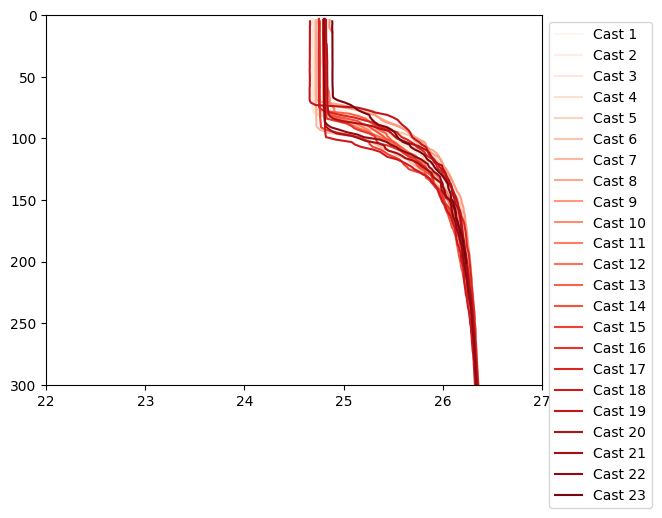

In [39]:
# Quick look at the sigma-theta profiles
#
for m,n in enumerate(N_cast):
    # extract a specific parameter from specific cast / cruise
    new_df = df.loc[(df.Cruise_num==cruise_num[k])&(df.Cast==n)]
    T = new_df['Temperature']
    QF_T = new_df['QF_Temperature']
    S = new_df['Salinity']
    QF_S = new_df['QF_Salinity']
    P = new_df['Pressure']
    QF_P = new_df['QF_Pressure']
    lon = new_df['Longitude_recovered']
    lat = new_df['Latitude_recovered']
    #
    # Apply QF check
    # Quality control flag for depth; Parameter quality flags defined as 1= unverified, 2= verified acceptable, 3= questionable, 4= bad, 9= no data
    T = np.where(QF_T==2,T,np.nan)
    S = np.where(QF_S==2,S,np.nan)
    P = np.where(QF_P==2,P,np.nan)
    #
    SA = gsw.SA_from_SP(S,P,lon,lat)
    CT = gsw.CT_from_t(SA,T,P)
    sig0=gsw.sigma0(SA,CT)
    #
    cmap=plt.get_cmap('Reds')
    plt.plot(sig0,P,color=cmap(m/np.max(N_cast)),label=f'Cast {n}')
#
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(300,0)
#plt.xlim(36.2,37.3)
#plt.xlim(15,30)
plt.xlim(22,27)
plt.show()

In [40]:
# extract a specific parameter from specific cast / cruise
new_df = df.loc[(df.Cruise_num==10387)&(df.Cast==20)]
T = new_df['Temperature'].to_numpy()
QF_T = new_df['QF_Temperature'].to_numpy()
S = new_df['Salinity'].to_numpy()
QF_S = new_df['QF_Salinity'].to_numpy()
P = new_df['Pressure'].to_numpy()
QF_P = new_df['QF_Pressure'].to_numpy()
lon = new_df['Longitude_recovered'].to_numpy()
lat = new_df['Latitude_recovered'].to_numpy()
#
# Apply QF check
# Quality control flag for depth; Parameter quality flags defined as 1= unverified, 2= verified acceptable, 3= questionable, 4= bad, 9= no data
T = np.where(QF_T==2,T,np.nan)
S = np.where(QF_S==2,S,np.nan)
P = np.where(QF_P==2,P,np.nan)

In [41]:
# Step 2 calculate sigma-theta
sa = gsw.SA_from_SP(S,P,lon,lat) # calculate absolute salinity
ct = gsw.CT_from_t(sa,T,P) # calculate conservative temperature
#
sigma0 = gsw.sigma0(sa,ct) # calculate sigma-theta

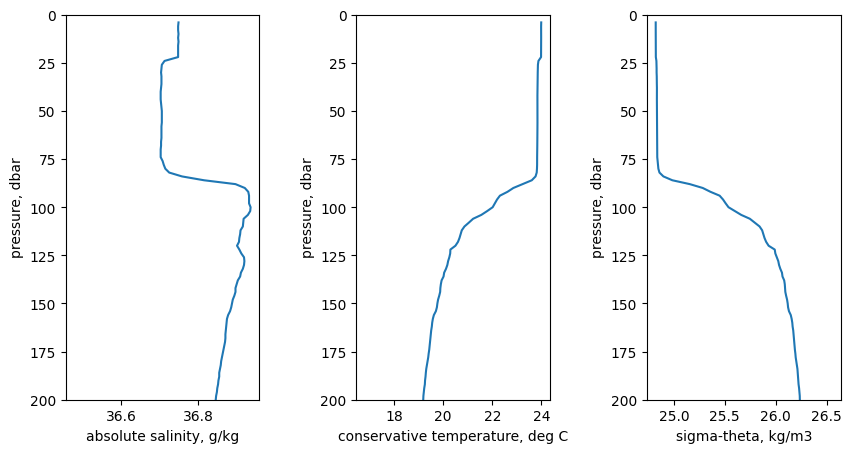

In [42]:
# plot
fig=plt.figure(figsize=(10,5))
ax=fig.subplots(1,3)
plt.subplots_adjust(wspace=0.5)
#
ax[2].plot(sigma0,P,label='sigma-theta')
ax[2].set_xlabel('sigma-theta, kg/m3')
ax[2].set_ylabel('pressure, dbar')
ax[2].set_ylim(200,0)
#
ax[0].plot(sa,P,label='SA')
ax[0].set_xlabel('absolute salinity, g/kg')
ax[0].set_ylabel('pressure, dbar')
ax[0].set_ylim(200,0)
#
ax[1].plot(ct,P,label='CT')
ax[1].set_xlabel('conservative temperature, deg C')
ax[1].set_ylabel('pressure, dbar')
ax[1].set_ylim(200,0)
plt.show()

### (b) Determine mixed layer depth using sigma-theta profile

In [43]:
# First calculate the surface value
sig0_surf = min(sigma0)
print(f'Surface sigma-theta = {np.round(sig0_surf,2)} kg/m3')

Surface sigma-theta = 24.82 kg/m3


In [44]:
# Start the loop
#
###### define density threshold
sig0_crit =
######
mld0=np.zeros(np.size(ct))
######
# mixed layer definition algorithm
for n,pres in enumerate(P):
    offset =
    if offset < sig0_crit:
      mld0[n] = P[n]
    else:
      mld0[n]=0
######
mld=np.max(mld0)
print(f'Mixed layer depth is {np.round(mld,2)} dbar level')

Mixed layer depth is 84.0 dbar level


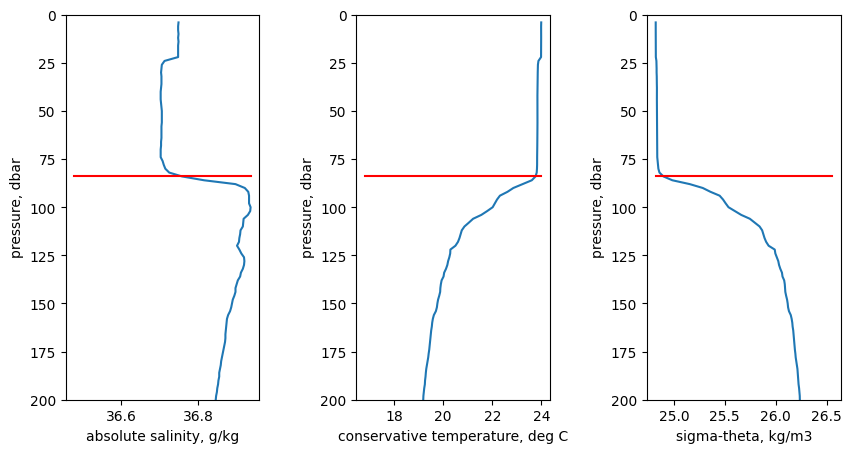

In [45]:
# plot
fig=plt.figure(figsize=(10,5))
ax=fig.subplots(1,3)
plt.subplots_adjust(wspace=0.5)
#
ax[2].plot(sigma0,P,label='sigma-theta')
ax[2].plot([min(sigma0), max(sigma0)],[mld, mld],'r',label='mixed layder depth')
ax[2].set_xlabel('sigma-theta, kg/m3')
ax[2].set_ylabel('pressure, dbar')
ax[2].set_ylim(200,0)
#
ax[0].plot(sa,P,label='SA')
ax[0].plot([min(sa), max(sa)],[mld, mld],'r',label='mixed layder depth')
ax[0].set_xlabel('absolute salinity, g/kg')
ax[0].set_ylabel('pressure, dbar')
ax[0].set_ylim(200,0)
#
ax[1].plot(ct,P,label='CT')
ax[1].plot([min(ct), max(ct)],[mld, mld],'r',label='mixed layder depth')
ax[1].set_xlabel('conservative temperature, deg C')
ax[1].set_ylabel('pressure, dbar')
ax[1].set_ylim(200,0)
plt.show()
